<a href="https://colab.research.google.com/github/aashay987/Computer_vision/blob/master/Canny_edge_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage import color
from skimage import io

In [47]:
def rgb2gray(image):
    image = cv2.cvtColor(src=image, code=cv2.COLOR_RGB2GRAY)
    return image

In [48]:
def conv(img,filter,padding=0,stride=1):
  #Fliping the filter for converting cross correlation to convolution
  filter = np.fliplr(np.flipud(filter))
  img_h = img.shape[0]
  img_w = img.shape[1]
  filter_h = filter.shape[0]
  filter_w = filter.shape[1]
  output_h = (img_h - filter_h + 2*padding)//stride + 1
  output_w = (img_w - filter_w + 2*padding)//stride + 1
  img_pad = np.zeros((img_h + 2*padding , img_w + 2*padding))
  img_pad[padding:padding+img_h, padding:padding+img_w] = img
  output=np.zeros((output_h,output_w))
  for i in range(output_h):
    for j in range(output_w):
      if i%stride==0 and j%stride==0:
        temp=(img_pad[i:i+filter_h,j:j+filter_w])*filter
        output[i,j]=temp.sum()
  return output



#Step 1: Noise reduction
Since edge detection is based on gradient calcultions, these gradients are very sensitive to noise. Hence noise is removed using a Gaussian filter.

In [49]:
def gaussian_kernel(size,sigma=1):
  size = int(size) // 2
  x, y = np.mgrid[-size:size+1, -size:size+1]
  normal = 1 / (2.0 * np.pi * sigma**2)
  g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
  return g

shape of input image is (512, 512)
shape of input image is (508, 508)


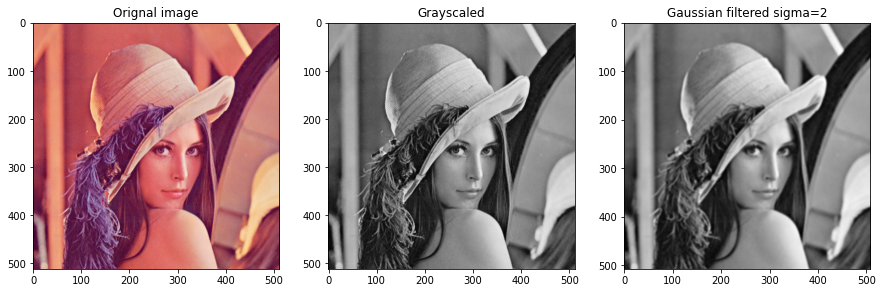

In [53]:
img=cv2.imread('/content/lena_C.png')
img_o = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
filter=gaussian_kernel(5,sigma=2)
#filter = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
img=rgb2gray(img_o)
output=conv(img,filter)
f, axes = plt.subplots(1,3,figsize=(15,15))
axes[0].imshow(img_o)
axes[0].set_title('Orignal image')
axes[1].imshow(img,cmap='gray')
axes[1].set_title('Grayscaled')
axes[2].imshow(output ,cmap="gray")
axes[2].set_title('Gaussian filtered sigma=2')
print('shape of input image is {0}'.format(img.shape))
print('shape of input image is {0}'.format(output.shape))
plt.show()

###Another Example


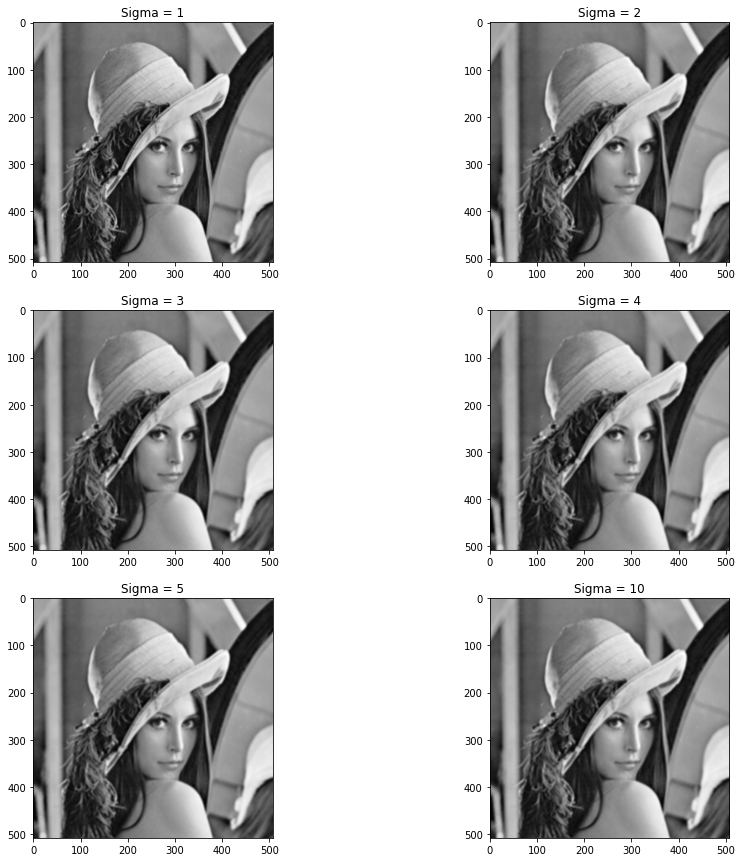

In [54]:
img=cv2.imread('/content/lena_C.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

filter1=gaussian_kernel(5,sigma=1)
filter2=gaussian_kernel(5,sigma=2)
filter3=gaussian_kernel(5,sigma=3)
filter4=gaussian_kernel(5,sigma=4)
filter5=gaussian_kernel(5,sigma=5)
filter6=gaussian_kernel(5,sigma=10)
img=rgb2gray(img)
output1=conv(img,filter1)
output2=conv(img,filter2)
output3=conv(img,filter3)
output4=conv(img,filter4)
output5=conv(img,filter5)
output6=conv(img,filter6)

f, axes = plt.subplots(3,2 ,figsize=(15,15))
axes[0][0].imshow(output1 , cmap= 'gray')
axes[0][0].set_title('Sigma = 1')

axes[0][1].imshow(output2 , cmap= 'gray')
axes[0][1].set_title('Sigma = 2')

axes[1][0].imshow(output3 , cmap= 'gray')
axes[1][0].set_title('Sigma = 3')

axes[1][1].imshow(output4 , cmap= 'gray')
axes[1][1].set_title('Sigma = 4')

axes[2][0].imshow(output5 , cmap= 'gray')
axes[2][0].set_title('Sigma = 5')

axes[2][1].imshow(output6 , cmap= 'gray')
axes[2][1].set_title('Sigma = 10')




plt.show()

#Step 2: Gradient Calculations
Edges corresponds to changes in intensity. Gradients are an easy ways to find edges. The magnitude and direction of the gradients is calculated.The pixels with the largest gradient values in the direction of the gradient become edge pixels, and edges may be traced in the direction perpendicular to the gradient direction.

## Sobel filter
Derivatives Ix and Iy w.r.t. x and y are calculated. It can be implemented by convolving with Sobel kernels.

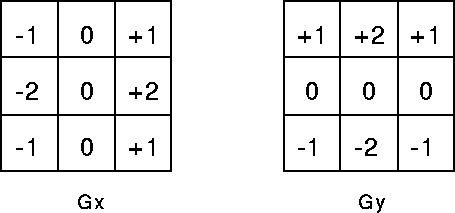

Then, the magnitude G and the slope θ of the gradient are calculated.
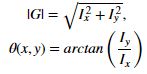






In [55]:
def sobel_filter(img):
  sob_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  sob_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
  Ix=conv(img,sob_x)
  Iy=conv(img,sob_y)
  G = np.sqrt(np.square(Ix) + np.square(Iy))
  G = G / G.max() * 255
  theta = np.arctan2(Iy, Ix)
  return G,theta

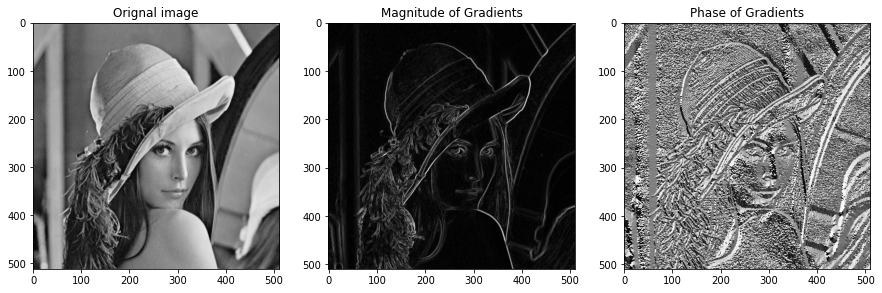

In [56]:
img=cv2.imread('/content/lena_C.png')
img_o = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=rgb2gray(img_o)
grad,phi =  sobel_filter(img)
f, axes = plt.subplots(1,3,figsize=(15,15))
axes[0].imshow(cv2.cvtColor(src=img_o, code=cv2.COLOR_RGB2GRAY), cmap='gray')
axes[0].set_title('Orignal image')
axes[1].imshow(grad, cmap='gray')
axes[1].set_title('Magnitude of Gradients')
axes[2].imshow(phi, cmap='gray')
axes[2].set_title('Phase of Gradients')
plt.show()

#Step 3: Non-max supression
From the above image, it can be noticed that the edges dont seem to be uniform. Some edges are thicker while others are thinner. 


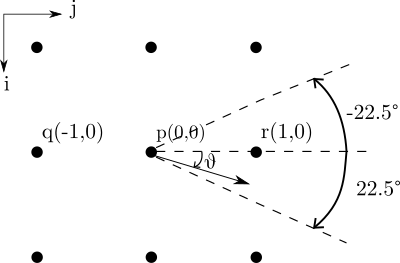

In [68]:
def non_max_sup(grad,theta):
  h,w = grad.shape
  result = np.zeros((h,w))
  theta = theta * 180. / np.pi
  theta[theta < 0] += 180
  # Theta (-180,180) --> (0,360)
  theta[theta<0] += 180

  for i in range(1,h-1):
    for j in range(1,w-1):

       if (0 <= theta[i,j] < 22.5) or (157.5 <= theta[i,j] <= 180):
         q = grad[i, j+1]
         r = grad[i, j-1]
         #theta 45
       elif (22.5 <= theta[i,j] < 67.5 ):
         q = grad[i+1, j-1]
         r = grad[i-1, j+1]

       elif (67.5 <= theta[i,j] < 112.5):
         q = grad[i+1, j]
         r = grad[i-1, j]
                
       elif (112.5 <= theta[i,j] < 157.5):
         q = grad[i-1, j-1]
         r = grad[i+1, j+1]

       if (grad[i,j] >= q) and (grad[i,j] >= r):
         result[i,j] = grad[i,j]
       else:
         result[i,j] = 0         
  return result

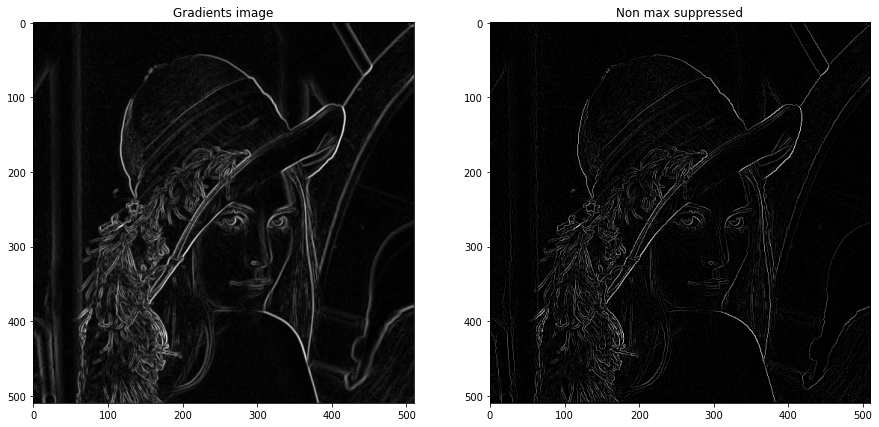

In [71]:
img=cv2.imread('/content/lena_C.png')
img_o = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = rgb2gray(img_o)
grad,phi =  sobel_filter(img)
output_nms = non_max_sup(grad,phi)
f, axes = plt.subplots(1,2,figsize=(15,15))
axes[0].imshow(grad, cmap='gray')
axes[0].set_title('Gradients image')
axes[1].imshow(output_nms, cmap='gray')
axes[1].set_title('Non max suppressed')
plt.show()

#Step 4: Double thresholding 
There may be edges be caused by noise or color variations for instance due to rough surfaces. To
discern between these would be to use a threshold, so that only edges stronger that a certainvalue would be preserved. The double threshold step aims at identifying 3 kinds of pixels: strong, weak, and non-relevant.

High threshold is used to identify the strong pixels (intensity higher than the high threshold)
Low threshold is used to identify the non-relevant pixels (intensity lower than the low threshold)
All pixels having intensity between both thresholds are flagged as weak and the Hysteresis mechanism (next step) will help us identify the ones that could be considered as strong and the ones that are considered as non-relevant.

In [128]:
def thresh(img, highThresholdRatio = 0.2, lowThresholdRatio =0.3):
  highThreshold = img.max() * highThresholdRatio
  lowThreshold = highThreshold * lowThresholdRatio
  M, N = img.shape
  res = np.zeros((M,N), dtype=np.int32)
  weak = np.int32(50)
  strong = np.int32(255)
    
  strong_i, strong_j = np.where(img >= highThreshold)
  zeros_i, zeros_j = np.where(img < lowThreshold)
   
  weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
  res[strong_i, strong_j] = strong
  res[weak_i, weak_j] = weak 
  return res

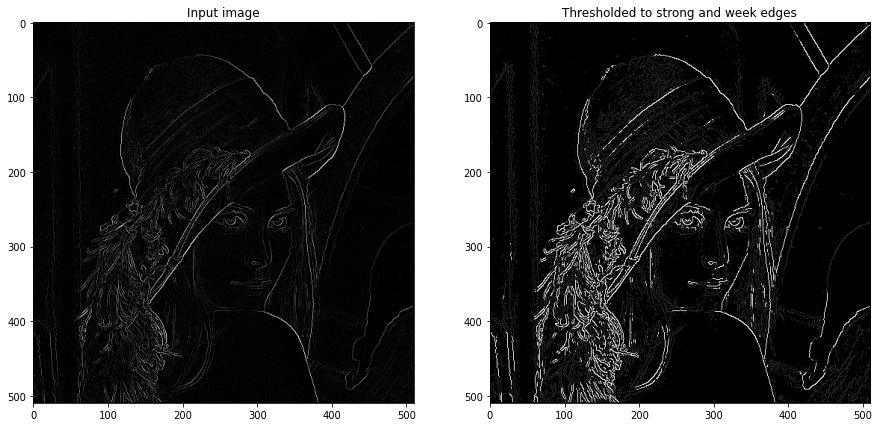

In [129]:
img=cv2.imread('/content/lena_C.png')
img_o = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = rgb2gray(img_o)
grad,phi =  sobel_filter(img)
output_nms = non_max_sup(grad,phi)
output_thresh = thresh(output_nms)
f, axes = plt.subplots(1,2,figsize=(15,15))
axes[0].imshow(output_nms, cmap='gray')
axes[0].set_title('Input image')
axes[1].imshow(output_thresh, cmap='gray')
axes[1].set_title('Thresholded to strong and week edges')
plt.show()

#Step 5: Edge Tracking by Hysteresis
Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one, as described below



In [130]:
def edge_track(img,weak=np.int32(50), strong = np.int32(255)):
  M, N = img.shape  
  for i in range(1, M-1):
      for j in range(1, N-1):
          if (img[i,j] == weak):
            if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or (img[i, j+1] == strong) or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
              img[i, j] = strong
            else:
              img[i, j] = 0
  return img

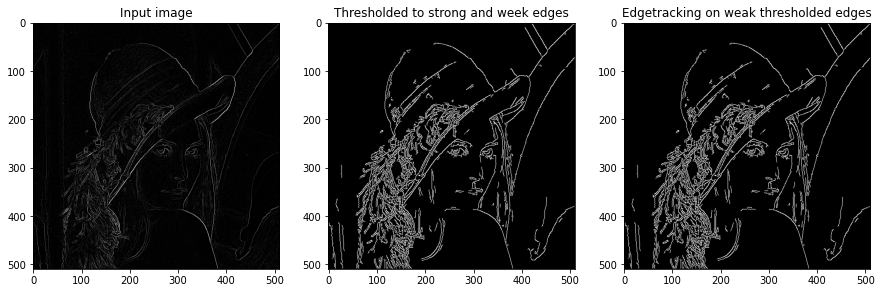

In [131]:
img=cv2.imread('/content/lena_C.png')
img_o = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = rgb2gray(img_o)
grad,phi =  sobel_filter(img)
output_nms = non_max_sup(grad,phi)
output_thresh = thresh(output_nms)
edge_track_output = edge_track(output_thresh)
f, axes = plt.subplots(1,3,figsize=(15,15))
axes[0].imshow(output_nms, cmap='gray')
axes[0].set_title('Input image')
axes[1].imshow(output_thresh, cmap='gray')
axes[1].set_title('Thresholded to strong and week edges')
axes[2].imshow(edge_track_output, cmap='gray')
axes[2].set_title('Edgetracking on weak thresholded edges')
plt.show()